# **Data Loading**

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# Memastikan kagglehub terinstal
try:
    import kagglehub
except ImportError:
    print("kagglehub tidak ditemukan, menginstal...")
    !pip install kagglehub[pandas-datasets]
    import kagglehub

file_paths = ["games.csv", "recommendations.csv"]
dataframes = {}

Mengecek dan menginstal kagglehub jika belum ada, lalu menyiapkan list file dan dictionary kosong untuk menyimpan data.

In [ ]:
# Memuat dua file dataset (games.csv dan recommendations.csv) dari Kaggle menggunakan kagglehub, lalu menyimpannya ke dalam dictionary untuk diakses dengan mudah.
for file in file_paths:
    df_loaded = kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        "antonkozyriev/game-recommendations-on-steam",
        file
    )
    dataframes[file] = df_loaded
    print(f"File '{file}' berhasil dimuat.")

# Mengambil isi dari masing-masing file ke variabel terpisah untuk proses selanjutnya.
games = dataframes["games.csv"]
recommendations = dataframes["recommendations.csv"]

<ipython-input-3-c33017a0adc7>:2: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df_loaded = kagglehub.load_dataset(


File 'games.csv' berhasil dimuat.


<ipython-input-3-c33017a0adc7>:2: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df_loaded = kagglehub.load_dataset(


File 'recommendations.csv' berhasil dimuat.


Memuat dataset dari Kaggle ke dictionary lalu menyimpan isinya ke variabel games dan recommendations.

# **Exploratory Data Analysis**

In [ ]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          50872 non-null  int64  
 1   title           50872 non-null  object 
 2   date_release    50872 non-null  object 
 3   win             50872 non-null  bool   
 4   mac             50872 non-null  bool   
 5   linux           50872 non-null  bool   
 6   rating          50872 non-null  object 
 7   positive_ratio  50872 non-null  int64  
 8   user_reviews    50872 non-null  int64  
 9   price_final     50872 non-null  float64
 10  price_original  50872 non-null  float64
 11  discount        50872 non-null  float64
 12  steam_deck      50872 non-null  bool   
dtypes: bool(4), float64(3), int64(3), object(3)
memory usage: 3.7+ MB


Tidak terdapat missing value pada tiap kolom di file games

In [ ]:
recommendations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
dtypes: bool(1), float64(1), int64(5), object(1)
memory usage: 2.2+ GB


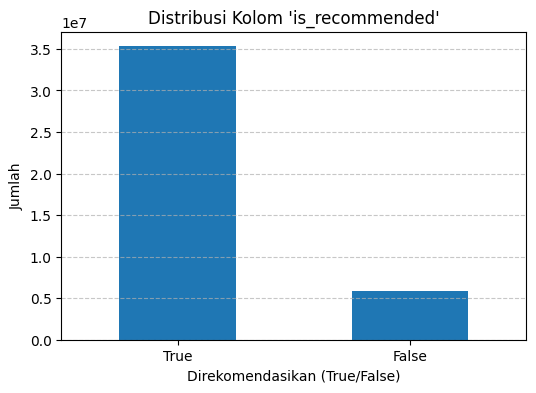

In [ ]:
# Bar plot perbandingan banyaknya data game yang direkomendasikan dan tidak
plt.figure(figsize=(6, 4))
recommendations.is_recommended.value_counts().plot(kind="bar")
plt.title("Distribusi Kolom 'is_recommended'")
plt.xlabel("Direkomendasikan (True/False)")
plt.ylabel("Jumlah")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Dari grafik terlihat bahwa jumlah user yang merekomendasikan game tertentu lebih banyak dibandingkan yang tidak merekomendasikan game yang tersebut.

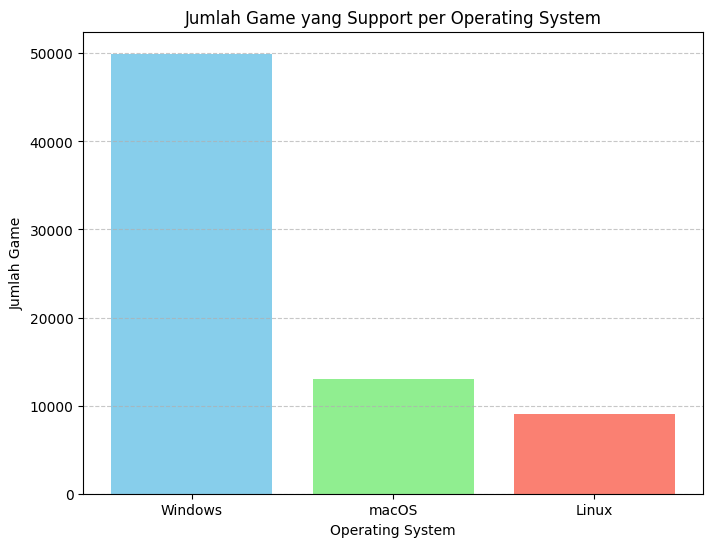

In [ ]:
# Bar plot jumlah game yang kompatibel pada setiap OS
plt.figure(figsize=(8, 6))
operating_systems = ['Windows', 'macOS', 'Linux']
game_counts = [len(games[games.win == True].title.unique()),
               len(games[games.mac == True].title.unique()),
               len(games[games.linux == True].title.unique())]

plt.bar(operating_systems, game_counts, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Jumlah Game yang Support per Operating System')
plt.xlabel('Operating System')
plt.ylabel('Jumlah Game')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Dari grafik terlihat bahwa game di Steam paling banyak kompatibel pada OS Windows daripada macOS dan Linux.

# **Data Preparation**

In [ ]:
# Inisialisasi dan fit LabelEncoder pada semua ID unik dari dataset asli
user_enc = LabelEncoder()
item_enc = LabelEncoder()
rating_enc = LabelEncoder()

print("Melatih encoder pada semua ID dan kategori unik dari dataset asli...")
user_enc.fit(recommendations['user_id'].unique())
item_enc.fit(games['app_id'].unique())
rating_enc.fit(games['rating'].unique())

n_users_overall = len(user_enc.classes_)
n_items_overall = len(item_enc.classes_)
print(f"Jumlah total pengguna unik (keseluruhan dataset): {n_users_overall}")
print(f"Jumlah total item unik (keseluruhan dataset): {n_items_overall}")

Melatih encoder pada semua ID dan kategori unik dari dataset asli...
Jumlah total pengguna unik (keseluruhan dataset): 13781059
Jumlah total item unik (keseluruhan dataset): 50872


Membuat dan melatih LabelEncoder untuk mengubah ID pengguna, ID game, dan kategori rating menjadi angka yang mudah diproses model. Kemudian mencetak jumlah total pengguna dan item unik yang ada di dataset.

In [ ]:
# Mengambil sampel data rekomendasi dan menggabungkan dengan data game
df_sampled = recommendations.sample(n=500_000, random_state=42).reset_index(drop=True)
df_merged = pd.merge(df_sampled, games, on='app_id', how='left')

# Mengidentifikasi fitur game yang relevan
selected_game_features = [
    'positive_ratio', 'user_reviews', 'price_final',
    'rating', 'win', 'mac', 'linux', 'steam_deck'
]

Mengambil sampel 500,000 data rekomendasi dan menggabungkan dengan fitur game...


Mengambil sampel 500.000 data rekomendasi secara acak, lalu menggabungkannya dengan data game berdasarkan app_id. Selanjutnya menentukan daftar fitur game yang akan digunakan untuk analisis atau model.

In [ ]:
df_merged_clean = df_merged.copy()

# Handle missing value kolom boolean dengan False
for col in ['win', 'mac', 'linux', 'steam_deck']:
    if col in df_merged_clean.columns:
        df_merged_clean[col].fillna(False, inplace=True)

# Handle missing value kolom rating dengan 'unknown'
if 'rating' in df_merged_clean.columns:
    df_merged_clean['rating'].fillna('Unknown', inplace=True)

# Handle missing value kolom numerik dengan nilai rata-rata
numerical_features = ['positive_ratio', 'user_reviews', 'price_final']
for col in numerical_features:
    if col in df_merged_clean.columns:
        df_merged_clean[col].fillna(games[col].mean(), inplace=True)

<ipython-input-9-c8937525a8b9>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged_clean[col].fillna(False, inplace=True)
<ipython-input-9-c8937525a8b9>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

Membuat salinan data gabungan, lalu mengisi nilai yang hilang seperti kolom boolean diisi dengan False, kolom rating diisi dengan 'Unknown', dan kolom numerik diisi dengan rata-rata nilai dari dataset game.

In [ ]:
# Drop ID yang hilang pada app dan user serta variabel target is_recommended
df_merged_clean.dropna(subset=['app_id', 'user_id', 'is_recommended'] + selected_game_features, inplace=True)
print(f"Ukuran DataFrame setelah merge, handle NaN, dan dropna: {df_merged_clean.shape}")
df_merged_clean.head()

Ukuran DataFrame setelah merge, handle NaN, dan dropna: (500000, 20)


,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,296630,0,0,2021-10-06,True,1.4,7837098,29073097,Kraven Manor,2014-09-26,True,False,False,Mostly Positive,75,621,0.00,0.00,0.0,True
1,307690,0,0,2016-11-30,True,27.0,11519298,14510346,Sleeping Dogs: Definitive Edition,2014-10-08,True,True,False,Very Positive,92,45096,19.99,19.99,0.0,True
2,405830,8,7,2017-03-16,True,9.8,10317527,11592042,Turok 2: Seeds of Evil,2017-03-16,True,True,True,Very Positive,93,1758,19.99,19.99,0.0,True
3,252330,6,13,2015-07-31,True,2.2,5688900,30257084,Slender: The Arrival,2013-10-28,True,True,False,Very Positive,88,6320,9.99,9.99,0.0,True
4,203770,0,0,2020-10-25,True,17.1,12483456,9101528,Crusader Kings II,2012-02-14,True,True,True,Very Positive,90,69388,0.00,0.00,0.0,True


Menghapus baris yang memiliki nilai hilang pada kolom app_id, user_id, is_recommended, dan fitur game terpilih.

In [ ]:
# Transformasi Data: Encoding dan Scaling
df_merged_clean['user_encoded'] = user_enc.transform(df_merged_clean['user_id'])
df_merged_clean['item_encoded'] = item_enc.transform(df_merged_clean['app_id'])

scaler = StandardScaler()
scaler.fit(games[numerical_features]) # Fit scaler pada games asli
df_merged_clean[numerical_features] = scaler.transform(df_merged_clean[numerical_features])

df_merged_clean['rating_encoded'] = rating_enc.transform(df_merged_clean['rating'])

Mengubah kolom user_id dan app_id menjadi angka menggunakan LabelEncoder. Kemudian fitur numerik dinormalisasi menggunakan StandardScaler yang sudah dilatih pada data game asli. Terakhir kolom rating juga diubah menjadi angka melalui encoding.

In [ ]:
# Membangun all_item_features_tensor
processed_games_df_full = games.copy()

for col in ['win', 'mac', 'linux', 'steam_deck']:
    processed_games_df_full[col].fillna(False, inplace=True)
processed_games_df_full['rating'].fillna('Unknown', inplace=True)
for col in numerical_features:
    processed_games_df_full[col].fillna(processed_games_df_full[col].mean(), inplace=True)

processed_games_df_full[numerical_features] = scaler.transform(processed_games_df_full[numerical_features])
processed_games_df_full['rating_encoded'] = rating_enc.transform(processed_games_df_full['rating'])

num_features_per_item = len(numerical_features) + 1 + 4
all_item_features_tensor = torch.zeros(n_items_overall, num_features_per_item, dtype=torch.float32)

for _, row in processed_games_df_full.iterrows():
    app_id = row['app_id']
    encoded_item_id = item_enc.transform([app_id])[0]
    features_data = row[numerical_features + ['rating_encoded', 'win', 'mac', 'linux', 'steam_deck']].values.astype(np.float32)
    all_item_features_tensor[encoded_item_id] = torch.tensor(features_data, dtype=torch.float32)

<ipython-input-12-949dcfd840ef>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  processed_games_df_full[col].fillna(False, inplace=True)
<ipython-input-12-949dcfd840ef>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

Memproses data game lengkap dengan mengisi nilai hilang dan melakukan scaling pada fitur numerik serta encoding rating. Kemudian membuat tensor PyTorch all_item_features_tensor yang menyimpan fitur lengkap setiap item (game) berdasarkan ID yang sudah diencode untuk digunakan dalam model.

In [ ]:
class SteamDatasetWithFeatures(Dataset):
    # Dataset user-item dengan fitur item lengkap
    def __init__(self, df_data, all_item_features_tensor_global):
        # Simpan data user, item, label, dan fitur item dalam bentuk tensor
        self.users = torch.tensor(df_data['user_encoded'].values, dtype=torch.long)
        self.items = torch.tensor(df_data['item_encoded'].values, dtype=torch.long)
        self.labels = torch.tensor(df_data['is_recommended'].values, dtype=torch.float32)
        self.all_item_features = all_item_features_tensor_global

    def __len__(self):
        # Jumlah data dalam dataset
        return len(self.users)

    def __getitem__(self, idx):
        # Ambil user, item, fitur item, dan label pada index idx
        user_id = self.users[idx]
        item_id = self.items[idx]
        label = self.labels[idx]
        item_features = self.all_item_features[item_id]
        return user_id, item_id, item_features, label

Class SteamDatasetWithFeatures menyimpan data user, item, label rekomendasi, dan fitur lengkap item dalam bentuk tensor. Fungsi __len__ mengembalikan jumlah data, dan fungsi __getitem__ mengembalikan user, item, fitur item, dan label pada indeks tertentu untuk digunakan dalam pelatihan model.

In [ ]:
# Split data menjadi train dan validation dengan stratifikasi label
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(
    df_merged_clean,
    df_merged_clean['is_recommended'],
    test_size=0.2,
    random_state=42,
    stratify=df_merged_clean['is_recommended']  # Jaga proporsi label tetap sama
)

# Buat dataset PyTorch untuk train dan validation
train_ds = SteamDatasetWithFeatures(X_train_df, all_item_features_tensor)
val_ds = SteamDatasetWithFeatures(X_val_df, all_item_features_tensor)

Membagi data menjadi data pelatihan dan validasi dengan menjaga proporsi label is_recommended tetap seimbang. Selanjutnya, kedua subset data tersebut diubah menjadi dataset PyTorch menggunakan class SteamDatasetWithFeatures untuk digunakan dalam pelatihan dan evaluasi model.

# **Model Development**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

class NeuMFWithFeatures(nn.Module):
    # Model NeuMF dengan embedding user-item dan fitur tambahan item
    def __init__(self, n_users, n_items, emb_size=32, num_item_features=0):
        super().__init__()
        # Embedding untuk user dan item
        self.user_emb = nn.Embedding(n_users, emb_size)
        self.item_emb = nn.Embedding(n_items, emb_size)

        # Input size untuk MLP = dua embedding + fitur item
        self.mlp_input_size = emb_size * 2 + num_item_features
        # MLP untuk memproses gabungan embedding dan fitur
        self.mlp = nn.Sequential(
            nn.Linear(self.mlp_input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        # Layer output menggabungkan hasil MLP dan GMF
        self.output_layer_input_size = 32 + emb_size
        self.output = nn.Linear(self.output_layer_input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, user, item, item_features):
        # Ambil embedding user dan item
        user_vec = self.user_emb(user)
        item_vec = self.item_emb(item)
        gmf = user_vec * item_vec                       # GMF: perkalian element-wise embedding user dan item

        # Input MLP: gabung embedding user, item, dan fitur item
        mlp_input = torch.cat([user_vec, item_vec, item_features], dim=1)
        mlp_output = self.mlp(mlp_input)
        x = torch.cat([gmf, mlp_output], dim=1)         # Gabungkan hasil GMF dan MLP untuk output akhir

        # Output probabilitas (0-1) rekomendasi
        return self.sigmoid(self.output(x)).squeeze()

Menggunakan device: cuda


Mendefinisikan model NeuMF dengan fitur tambahan item. Model ini memiliki embedding untuk user dan item, lalu memproses gabungan embedding dan fitur item lewat MLP, menggabungkan hasil MLP dan GMF (perkalian element-wise embedding user-item), dan mengeluarkan skor rekomendasi berupa probabilitas antara 0 dan 1 menggunakan fungsi sigmoid.

In [ ]:
# Inisialisasi model, optimizer, dan loss function
num_features_per_item = num_features_per_item
model = NeuMFWithFeatures(n_users_overall, n_items_overall, emb_size=32, num_item_features=num_features_per_item).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()
num_epochs = 3

# Lists untuk menyimpan metrik
train_losses = []
val_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}
train_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}

Menginisialisasi model NeuMF dengan fitur tambahan sesuai jumlah user, item, dan fitur item, lalu mengatur optimizer Adam dengan learning rate 0.001 dan fungsi loss binary cross-entropy (BCELoss). Kemudian memvuat variabel untuk menyimpan metrik evaluasi selama pelatihan dan validasi, seperti akurasi, presisi, recall, dan F1-score dengan jumlah epoch pelatihan ditetapkan sebanyak 3.

In [ ]:
batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, pin_memory=True)

# Kosongkan cache CUDA sebelum pelatihan
torch.cuda.empty_cache()

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for users, items, item_features, labels in train_loader:
        users, items, item_features, labels = users.to(device), items.to(device), item_features.to(device), labels.to(device)
        preds = model(users, items, item_features)
        loss = loss_fn(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * users.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluasi Pelatihan
    model.eval()
    all_preds_train, all_labels_train = [], []
    with torch.no_grad():
        for users, items, item_features, labels in train_loader:      # Menggunakan train_loader untuk evaluasi pelatihan
            users, items, item_features, labels = users.to(device), items.to(device), item_features.to(device), labels.to(device)
            preds = model(users, items, item_features)
            preds_bin = (preds > 0.5).float()
            all_preds_train.extend(preds_bin.cpu().numpy())
            all_labels_train.extend(labels.cpu().numpy())

    train_acc = accuracy_score(all_labels_train, all_preds_train)
    train_prec = precision_score(all_labels_train, all_preds_train, zero_division=0)
    train_rec = recall_score(all_labels_train, all_preds_train, zero_division=0)
    train_f1 = f1_score(all_labels_train, all_preds_train, zero_division=0)

    train_metrics['accuracy'].append(train_acc)
    train_metrics['precision'].append(train_prec)
    train_metrics['recall'].append(train_rec)
    train_metrics['f1_score'].append(train_f1)

    # Evaluasi Validasi
    model.eval()
    all_preds_val, all_labels_val = [], []
    with torch.no_grad():
        for users, items, item_features, labels in val_loader:
            users, items, item_features, labels = users.to(device), items.to(device), item_features.to(device), labels.to(device)
            preds = model(users, items, item_features)
            preds_bin = (preds > 0.5).float()
            all_preds_val.extend(preds_bin.cpu().numpy())
            all_labels_val.extend(labels.cpu().numpy())

    val_acc = accuracy_score(all_labels_val, all_preds_val)
    val_prec = precision_score(all_labels_val, all_preds_val, zero_division=0)
    val_rec = recall_score(all_labels_val, all_preds_val, zero_division=0)
    val_f1 = f1_score(all_labels_val, all_preds_val, zero_division=0)

    val_metrics['accuracy'].append(val_acc)
    val_metrics['precision'].append(val_prec)
    val_metrics['recall'].append(val_rec)
    val_metrics['f1_score'].append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc:.4f}, Prec: {train_prec:.4f}, Rec: {train_rec:.4f}, F1: {train_f1:.4f} | "
          f"Val Acc: {val_acc:.4f}, Prec: {val_prec:.4f}, Rec: {val_rec:.4f}, F1: {val_f1:.4f}")

Epoch 1/3 - Train Loss: 0.3708 | Train Acc: 0.8627, Prec: 0.8662, Rec: 0.9934, F1: 0.9255 | Val Acc: 0.8614, Prec: 0.8657, Rec: 0.9925, F1: 0.9248
Epoch 2/3 - Train Loss: 0.3580 | Train Acc: 0.8638, Prec: 0.8658, Rec: 0.9956, F1: 0.9262 | Val Acc: 0.8614, Prec: 0.8649, Rec: 0.9938, F1: 0.9249
Epoch 3/3 - Train Loss: 0.3483 | Train Acc: 0.8682, Prec: 0.8729, Rec: 0.9907, F1: 0.9281 | Val Acc: 0.8599, Prec: 0.8686, Rec: 0.9860, F1: 0.9236


Model melakukan pelatihan pada set training dan validasi. Dari hasil, didapatkan akurasi, presisi, recall, dan F1-score yang tinggi dan konsisten di tiap epoch baik pada set akurasi maupun validasi.

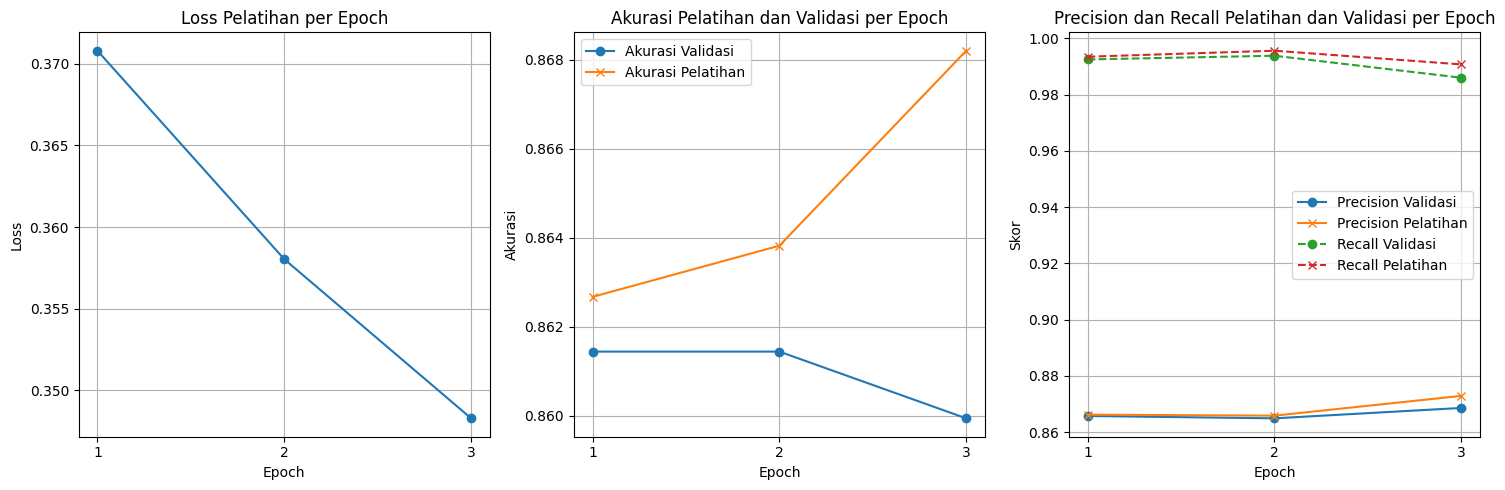

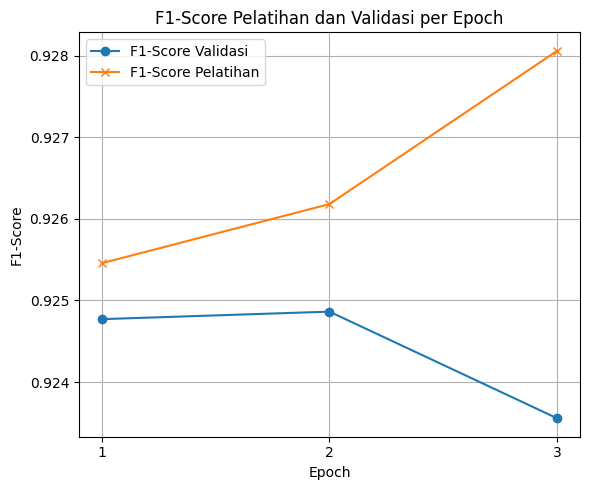

In [ ]:
# Plot training loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title("Loss Pelatihan per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, num_epochs+1))
plt.grid(True)

# Plot Akurasi
plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), val_metrics['accuracy'], label="Akurasi Validasi", marker='o')
plt.plot(range(1, num_epochs+1), train_metrics['accuracy'], label="Akurasi Pelatihan", marker='x')
plt.title("Akurasi Pelatihan dan Validasi per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.xticks(range(1, num_epochs+1))
plt.legend()
plt.grid(True)

# Plot Precision & Recall
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), val_metrics['precision'], label="Precision Validasi", marker='o')
plt.plot(range(1, num_epochs+1), train_metrics['precision'], label="Precision Pelatihan", marker='x')
plt.plot(range(1, num_epochs+1), val_metrics['recall'], label="Recall Validasi", marker='o', linestyle='--')
plt.plot(range(1, num_epochs+1), train_metrics['recall'], label="Recall Pelatihan", marker='x', linestyle='--')
plt.title("Precision dan Recall Pelatihan dan Validasi per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Skor")
plt.xticks(range(1, num_epochs+1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot F1-Score
plt.figure(figsize=(6, 5))
plt.plot(range(1, num_epochs+1), val_metrics['f1_score'], label="F1-Score Validasi", marker='o')
plt.plot(range(1, num_epochs+1), train_metrics['f1_score'], label="F1-Score Pelatihan", marker='x')
plt.title("F1-Score Pelatihan dan Validasi per Epoch")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.xticks(range(1, num_epochs+1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Dari semua plot ini menggambarkan bahwa hasil evaluasi cukup baik, tidak terdapat penurunan nilai yang signifikan pada setiap evaluasi. Serta tidak ada gap yang besar pada hasil evaluasi antara set training dan validasi. Hal ini menandakan bahwa model tidak terdampak overfitting.

In [ ]:
def get_game_recommendations_with_features(user_id, model, user_enc, item_enc, games_df, recommendations_df, scaler, rating_enc, numerical_features, all_item_features_tensor, top_k=10):
    """
    Menghasilkan rekomendasi game untuk user tertentu menggunakan model NeuMF dengan fitur tambahan.

    Args:
        user_id (str/int): ID user asli yang ingin direkomendasikan game.
        model (nn.Module): Model PyTorch yang sudah dilatih.
        user_enc (LabelEncoder): Encoder untuk mengubah user_id ke indeks internal.
        item_enc (LabelEncoder): Encoder untuk mengubah app_id game ke indeks internal.
        games_df (pd.DataFrame): Dataframe berisi informasi lengkap tentang semua game.
        recommendations_df (pd.DataFrame): Dataframe interaksi user-game (user_id, app_id).
        scaler (sklearn scaler): Scaler yang digunakan untuk menormalisasi fitur numerik game.
        rating_enc (LabelEncoder): Encoder untuk fitur kategori rating game.
        numerical_features (list): List nama kolom fitur numerik pada games_df.
        all_item_features_tensor (torch.Tensor): Tensor berisi fitur semua item (tidak dipakai langsung di fungsi ini).
        top_k (int, optional): Jumlah rekomendasi teratas yang ingin dikembalikan. Default 10.

    Returns:
        final_recommendations_df (pd.DataFrame): Dataframe berisi game-game yang direkomendasikan beserta skor prediksi.
        user_played_games_original (np.array): Array game yang sudah dimainkan user (app_id asli).
    """
    model.eval()

    try:
        encoded_user = user_enc.transform([user_id])[0]
    except ValueError:
        print(f"User ID {user_id} tidak ditemukan dalam data pelatihan.")
        return pd.DataFrame(), pd.Series()

    user_played_games_original = recommendations_df[recommendations_df['user_id'] == user_id]['app_id'].unique()

    all_game_app_ids = games_df['app_id'].unique()
    unplayed_game_app_ids = np.array([
        app_id for app_id in all_game_app_ids if app_id not in user_played_games_original
    ])

    if len(unplayed_game_app_ids) == 0:
        print(f"Pengguna {user_id} telah berinteraksi dengan semua game yang tersedia. Tidak ada rekomendasi baru.")
        return pd.DataFrame(), user_played_games_original

    unplayed_games_info = games_df[games_df['app_id'].isin(unplayed_game_app_ids)].copy()

    for col in ['win', 'mac', 'linux', 'steam_deck']:
        if col in unplayed_games_info.columns:
            unplayed_games_info[col].fillna(False, inplace=True)
    if 'rating' in unplayed_games_info.columns:
        unplayed_games_info['rating'].fillna('Unknown', inplace=True)
    for col in numerical_features:
        if col in unplayed_games_info.columns:
            unplayed_games_info[col].fillna(games_df[col].mean(), inplace=True)

    unplayed_games_info.dropna(subset=numerical_features + ['rating', 'win', 'mac', 'linux', 'steam_deck'], inplace=True)
    if unplayed_games_info.empty:
        print(f"Tidak ada game yang belum dimainkan dengan fitur lengkap untuk pengguna {user_id}.")
        return pd.DataFrame(), user_played_games_original

    unplayed_games_info['rating_encoded'] = rating_enc.transform(unplayed_games_info['rating'])
    unplayed_games_info[numerical_features] = scaler.transform(unplayed_games_info[numerical_features])

    unplayed_game_features_processed = unplayed_games_info[numerical_features + ['rating_encoded', 'win', 'mac', 'linux', 'steam_deck']].values.astype(np.float32)

    unplayed_item_encoded_ids = item_enc.transform(unplayed_games_info['app_id'])

    user_tensor = torch.tensor([encoded_user] * len(unplayed_item_encoded_ids), dtype=torch.long, device=device)
    items_tensor = torch.tensor(unplayed_item_encoded_ids, dtype=torch.long, device=device)
    features_tensor = torch.tensor(unplayed_game_features_processed, dtype=torch.float32, device=device)

    with torch.no_grad():
        predicted_scores = model(user_tensor, items_tensor, features_tensor).cpu().numpy().flatten()

    top_k_indices = predicted_scores.argsort()[-top_k:][::-1]

    if len(top_k_indices) == 0:
        print(f"Tidak ada rekomendasi yang bisa dihasilkan untuk pengguna {user_id} setelah filtering.")
        return pd.DataFrame(), user_played_games_original

    recommended_item_ids_encoded = unplayed_item_encoded_ids[top_k_indices]
    recommended_scores = predicted_scores[top_k_indices]

    recommended_app_ids = item_enc.inverse_transform(recommended_item_ids_encoded)

    final_recommendations_df = games_df[games_df['app_id'].isin(recommended_app_ids)].copy()

    score_map_final = pd.Series(recommended_scores, index=recommended_app_ids)
    final_recommendations_df['predicted_score'] = final_recommendations_df['app_id'].map(score_map_final)
    final_recommendations_df = final_recommendations_df.sort_values(by='predicted_score', ascending=False).reset_index(drop=True)

    return final_recommendations_df, user_played_games_original

Fungsi ini menghasilkan rekomendasi item untuk user tertentu menggunakan model yang sudah dilatih. Ini memproses data fitur item, memilih item yang belum pernah digunakan oleh user, kemudian memprediksi dan mengembalikan daftar rekomendasi terbaik beserta skor prediksinya. Jika user tidak ditemukan atau tidak ada item baru, fungsi mengembalikan hasil kosong.

In [ ]:
# Memilih pengguna acak dari data `recommendations` asli
random_user_id_original = recommendations['user_id'].sample(1, random_state=42).iloc[0]

# Mendapatkan rekomendasi
recommended_games_df, user_played_games_original_list = get_game_recommendations_with_features(
    random_user_id_original, model, user_enc, item_enc, games, recommendations, scaler, rating_enc, numerical_features, all_item_features_tensor
)

<ipython-input-19-74da3a756055>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  unplayed_games_info[col].fillna(False, inplace=True)
<ipython-input-19-74da3a756055>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

Memilih satu pengguna secara acak dari data rekomendasi asli lalu memanggil fungsi rekomendasi untuk mendapatkan daftar game yang direkomendasikan untuk pengguna tersebut beserta daftar game yang sudah pernah dimainkan.

In [ ]:
# Menampilkan game yang sudah dimainkan pengguna
played_games_info = games[games['app_id'].isin(user_played_games_original_list)][['app_id', 'title', 'rating', 'win', 'mac', 'linux']]
print(f"\nGame yang sudah dimainkan oleh pengguna {random_user_id_original}:")
played_games_info


Game yang sudah dimainkan oleh pengguna 7837098:


,app_id,title,rating,win,mac,linux
1117,468920,Ultimate Fishing Simulator,Very Positive,True,False,False
3800,864060,Marble It Up!,Very Positive,True,True,False
5845,332800,Five Nights at Freddy's 2,Very Positive,True,False,False
9126,239200,Amnesia: A Machine for Pigs,Mixed,True,True,True
9433,327890,I Am Bread,Mostly Positive,True,True,False
13203,739630,Phasmophobia,Overwhelmingly Positive,True,False,False
13224,22180,Penumbra Overture,Very Positive,True,True,True
13805,270880,American Truck Simulator,Overwhelmingly Positive,True,True,True
14732,750130,The Sinking City,Mostly Positive,True,False,False
15040,620,Portal 2,Overwhelmingly Positive,True,True,True


Pengguna 7837098 pernah memainkan 25 game yang terdapat pada dataframe di atas beserta informasi-informasi terkait game tersebut.

In [ ]:
# Menampilkan rekomendasi 10 game berdasarkan game yang telah dimainkan pengguna
print(f"\nTop 10 Rekomendasi Game Baru untuk pengguna {random_user_id_original}:")
recommended_games_df


Top 10 Rekomendasi Game Baru untuk pengguna 7837098:


,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,predicted_score
0,1292940,Cube Escape Collection,2020-10-14,True,True,False,Overwhelmingly Positive,98,4149,4.99,4.99,0.0,True,0.992425
1,667970,VTOL VR,2017-08-03,True,False,False,Overwhelmingly Positive,98,11883,30.00,0.00,0.0,True,0.991820
2,1583720,Entropy : Zero 2,2022-08-20,True,False,False,Overwhelmingly Positive,98,14612,0.00,0.00,0.0,True,0.991582
3,1189190,Battle Map Studio,2021-10-20,True,True,False,Positive,100,10,11.99,15.99,25.0,True,0.991194
4,2147640,Chacara,2022-10-19,True,False,True,Positive,100,17,2.99,2.99,0.0,True,0.990662
5,1409180,Of Mice and Moggies,2021-02-23,True,True,True,Positive,100,22,4.99,4.99,0.0,True,0.990609
6,1095960,Zeliria Sanctuary - Rise of Pumpkins,2019-06-07,True,True,True,Positive,100,11,0.00,0.00,0.0,True,0.990422
7,2266310,REFLEXIA Prototype ver. Original Graphics,2023-01-11,True,False,True,Positive,100,16,2.99,2.99,0.0,True,0.990254
8,277762,Train Simulator: CSX NRE 3GS-21B 'Genset' Loco...,2015-03-05,True,False,False,Positive,100,17,19.99,19.99,0.0,True,0.989872
9,1289310,Helltaker,2020-05-11,True,True,True,Overwhelmingly Positive,97,110173,0.00,0.00,0.0,True,0.989774


Berdasarkan game yang pernah dimainkan pengguna 7837098 sebelumnya, sistem merekomendasikan 10 game yang paling relevan dan terkait berdasarkan fitur-fitur seperti title, positive ratio, reviews, price final, dan OS yang kompatibel.